In [12]:
import numpy as np
import fitsio as fio
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt

In [43]:
cent = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p20_fmasked.fits')[-1] # Central galaxy catalog (with shapes)
sat = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p20_fmasked.fits')[-1] # Satellite p_mem >= 0.2 catalog
cent_3 = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p20_im3shape.fits')[-1]
sat_3 = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p20_im3shape.fits')[-1]

In [3]:
def sat_num(sat=sat.read()):
    sat_id_unq, counts = np.unique(sat['MEM_MATCH_ID'], return_counts=True)
    clus_n = len(sat_id_unq)
    sat_max = np.amax(counts)
    
    return sat_id_unq, counts, clus_n, sat_max

In [4]:
sat_id_unq, counts, clus_n, sat_max = sat_num()

In [5]:
# Create 2D array for specified property of all satellite galaxies
def sat_prop(prop, sat=sat.read()):
    sat_id_unq, counts, clus_n, sat_max = sat_num(sat)
    sat_prop_full = sat[prop]
    new_array = np.zeros((clus_n,sat_max))
    k = 0
    for i in range(clus_n):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [16]:
# Calculate satellite angular position (in radians) for all clusters
def sat_ang_pos(cent=cent, sat=sat):
    sat_ra = np.radians(sat_prop('RA'))
    sat_dec = np.radians(sat_prop('DEC'))
    cent_ra = np.radians(cent['RA'].read().reshape((clus_n,-1)))
    cent_dec = np.radians(cent['DEC'].read().reshape((clus_n,-1)))
    x = np.sin(sat_dec) * np.cos(cent_dec) - np.cos(sat_dec) * np.sin(cent_dec) * np.cos(sat_ra-cent_ra)
    y = np.sin(sat_ra-cent_ra) * np.cos(sat_dec)
    theta = np.arctan2(y, x)
    
    return theta

In [17]:
sat_pos = sat_ang_pos() # Store satellite angular positions

In [18]:
# Calculate number of satellites in each quadrant with respect to input angle (in degrees) for all clusters
def q_counts(theta):
    theta = np.radians(theta)
    nan_mask = np.isnan(sat_pos)
    dif = sat_pos - theta
    x = np.cos(dif)
    y = np.sin(dif)
    x[nan_mask] = 0
    y[nan_mask] = 0
    q1 = np.sum(np.logical_and(x>0, y>0), axis=1)
    q2 = np.sum(np.logical_and(x<0, y>0), axis=1)
    q3 = np.sum(np.logical_and(x<0, y<0), axis=1)
    q4 = np.sum(np.logical_and(x>0, y<0), axis=1)
    
    return np.array([q1, q2, q3, q4])

In [19]:
# Calculate q1 + q3 - (q2 + q4) for all clusters, positive indicates cluster PA is in positive direction relative to theta
def q_dif(theta):
    q_i = q_counts(theta)
    dif = q_i[0] + q_i[2] - q_i[1] - q_i[3]
    
    return dif

In [20]:
# Calculate dif for angles 0 to 90 (not including 90) with n steps
def q_array(n):
    new_array = np.zeros((n, clus_n))
    for i in range(n):
        dif_i = q_dif(90*i/n)
        new_array[i] = dif_i
    
    return new_array

In [21]:
#model = counts_test/np.pi*(np.arctan2(ratio_test*np.sin(theta_test-phase_test+np.pi/2),np.cos(theta_test-phase_test+np.pi/2))-
#                           np.arctan2(ratio_test*np.sin(theta_test-phase_test),np.cos(theta_test-phase_test)))

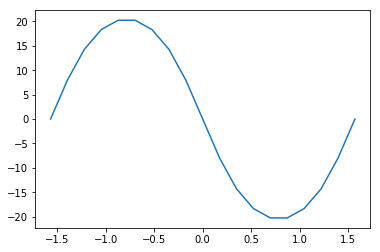

In [22]:
theta_test = np.radians(np.arange(-90., 100., 10))
phase_test = 0.
ratio_test = 2.
counts_test = 100.
model_test = counts_test/(2*np.pi)*(np.arctan2(ratio_test*np.sin(theta_test-phase_test+np.pi/2),np.cos(theta_test-phase_test+np.pi/2))+
                                     np.arctan2(ratio_test*np.sin(theta_test-phase_test-np.pi/2),np.cos(theta_test-phase_test-np.pi/2))-
                                     2*np.arctan2(ratio_test*np.sin(theta_test-phase_test),np.cos(theta_test-phase_test)))
plt.plot(theta_test, model_test)
plt.show()

In [23]:
n = 10
q_n_array = q_array(n)
theta_n = np.radians(np.arange(n)*90/n)

In [24]:
def chisqfunc(x, clus_i):
    """
    Calculate chi squared for model fit. Input: phase and ratio. Returns chisq.
    """
    phase, ratio = x
    theta        = theta_n
    model        = counts[clus_i]/(2*np.pi)*(np.arctan2(ratio*np.sin(theta-phase+np.pi/2),np.cos(theta-phase+np.pi/2))+
                                             np.arctan2(ratio*np.sin(theta-phase-np.pi/2),np.cos(theta-phase-np.pi/2))-
                                             2*np.arctan2(ratio*np.sin(theta-phase),np.cos(theta-phase)))
    data         = q_n_array[:,clus_i]
    variance     = 1./np.sqrt(counts[clus_i]/n)
    chisq        = np.sum((data-model)**2/variance)
    
    return chisq

In [25]:
def chisq_opt(clus_i):
    """
    Optimize chisqfunc over phase and ratio. Input: number of angle steps and cluster index. Returns opt result.
    """
    x0 = np.array([np.pi/4, 1.])
    bounds = ((0, np.pi/2.), (0., 10.))
    result = opt.minimize(chisqfunc, x0, clus_i, bounds=bounds)
    
    return result

In [26]:
def chisq_opt_iter():
    """
    Iterate chi squared optimization over all clusters. Returns clus_n by 2 array with each row containing phase, ratio
    """
    new_array = np.zeros((clus_n, 2))
    for i in range(clus_n):
        phase_i, ratio_i = chisq_opt(i).x
        new_array[i] = np.array([phase_i, ratio_i])
    
    return new_array

In [27]:
def clus_pa():
    opt_array = chisq_opt_iter()
    r_mask = opt_array[:,1] < 1
    opt_array[r_mask,0] = opt_array[r_mask,0] - np.pi/2
    beta = opt_array[:,0]
    
    return beta

In [28]:
# Calculate position angle
def pos_ang(e1, e2):
    alpha = np.arctan2(-e2, -e1) / 2
    
    return alpha

In [29]:
def clus_align_ang():
    clus_ang = clus_pa()
    cent_ang = pos_ang(cent['e1'].read(), cent['e2'].read())
    delta = clus_ang - cent_ang
    delta = np.arcsin(np.abs(np.sin(delta)))
    delta = np.degrees(delta)
    
    return delta

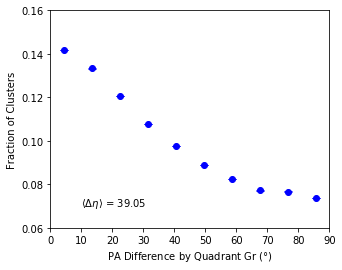

In [39]:
# Plot histogram of cluster alignment angle (with standard error of the mean)
clus_align = clus_align_ang()
n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = clus_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+4.5, n/clus_n, yerr=new_array/clus_n, fmt='bo', capsize=4)
plt.xlabel(r'PA Difference by Quadrant Gr ($\degree$)')
plt.ylabel('Fraction of Clusters')
plt.text(10, 0.07, fr'$\langle \Delta \eta \rangle$ = {np.sum(clus_align)/clus_n:.2f}')
plt.xlim(0, 90)
plt.ylim(0.06, 0.16)
f = plt.gcf()
f.set_size_inches(5., 4.)
plt.show()

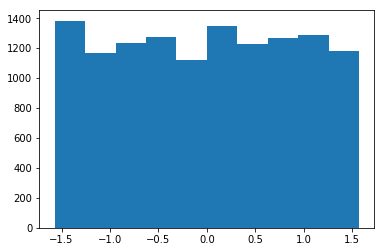

In [37]:
clus_ang = clus_pa()
plt.hist(clus_ang)
plt.show()

In [40]:
np.mean(clus_align)

39.05305813213238

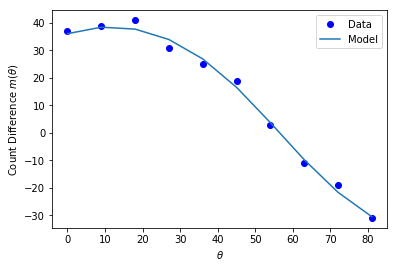

In [41]:
i = 0
phase_i, ratio_i = chisq_opt(0).x
model_i = counts[i]/(2*np.pi)*(np.arctan2(ratio_i*np.sin(theta_n-phase_i+np.pi/2),np.cos(theta_n-phase_i+np.pi/2))+
                                             np.arctan2(ratio_i*np.sin(theta_n-phase_i-np.pi/2),np.cos(theta_n-phase_i-np.pi/2))-
                                             2*np.arctan2(ratio_i*np.sin(theta_n-phase_i),np.cos(theta_n-phase_i)))
plt.plot(np.rad2deg(theta_n), q_n_array[:,i], 'bo', label='Data')
plt.plot(np.rad2deg(theta_n), model_i, label='Model')
plt.xlabel(r'$\theta$')
plt.ylabel(r'Count Difference $m(\theta)$')
plt.legend()
plt.show()

In [42]:
fio.write('/lsst/troxel/y1a1/lgt20_clus_ang_quad.fits', clus_ang, clobber=True)